<a href="https://colab.research.google.com/github/reshmaamarane/EEG-emotion--AUDIO-BOT/blob/main/PREPROCESS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install scipy numpy pandas pywt matplotlib



ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


In [2]:
!pip install PyWavelets==1.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 50.6 MB/s eta 0:00:00


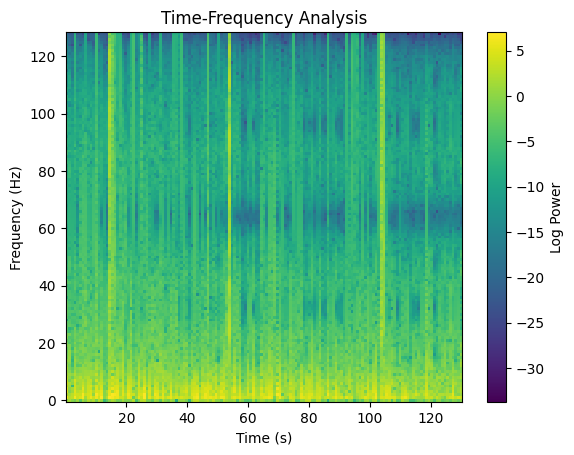

Saved processed data to processed_eeg_data.csv


In [3]:
import numpy as np
import scipy.io
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# **STEP 1: Load EEG Data from .mat File**
def load_mat_file(file_path):
    mat = scipy.io.loadmat(file_path)
    for key in mat.keys():
        if isinstance(mat[key], np.ndarray):  # Assuming EEG data is stored in an array
            eeg_data = mat[key]
            break  # Extract the first ndarray found
    return eeg_data

# **STEP 2: Multi-Scale Principal Component Analysis (MSPCA)**
def apply_mspca(data, wavelet='db4', level=4):
    coeffs = pywt.wavedec(data, wavelet, level=level)

    # Thresholding to remove noise
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(data)))

    # Apply soft thresholding
    denoised_coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

    # Reconstruct the signal
    denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
    return denoised_signal

# **STEP 3: Joint Time-Frequency Analysis (JTFA)**
def apply_jtfa(data, fs=256):  # Assuming 256 Hz sampling rate
    f, t, Sxx = spectrogram(data, fs)

    # Plot the Spectrogram
    plt.pcolormesh(t, f, np.log(Sxx))
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.title('Time-Frequency Analysis')
    plt.colorbar(label='Log Power')
    plt.show()

    return f, t, Sxx  # Return spectrogram data if needed

# **STEP 4: Save Processed Data to CSV**
def save_to_csv(data, filename="processed_eeg_data.csv"):
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Saved processed data to {filename}")

# **MAIN FUNCTION**
if __name__ == "__main__":
    file_path = "/content/1_20160518.mat"  # Change this to your actual .mat file path
    eeg_data = load_mat_file(file_path)

    # Apply MSPCA on each EEG channel
    processed_data = np.array([apply_mspca(channel) for channel in eeg_data])

    # Perform Joint Time-Frequency Analysis on the first EEG channel
    apply_jtfa(processed_data[0])

    # Save the processed EEG data
    save_to_csv(processed_data.T)  # Transpose to match CSV format (channels as columns)


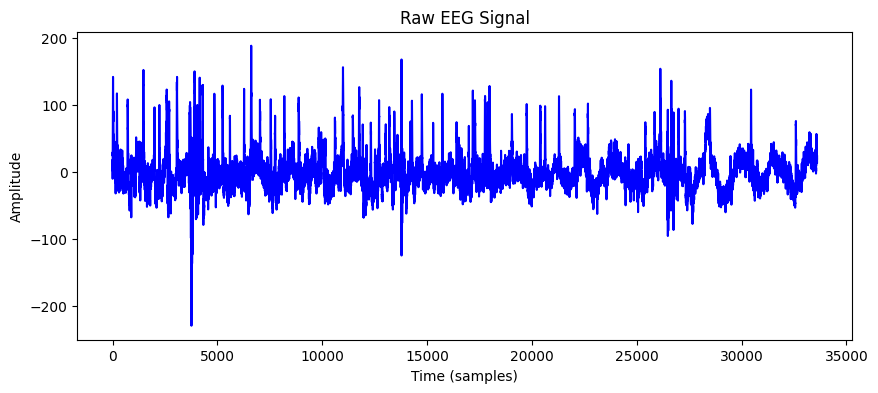

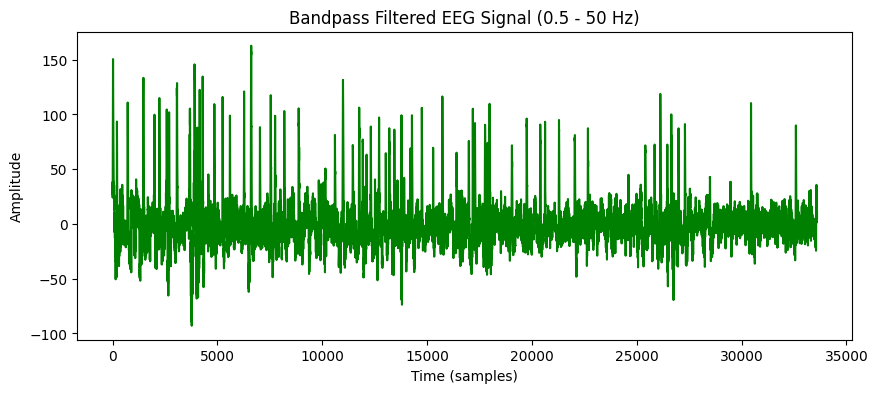

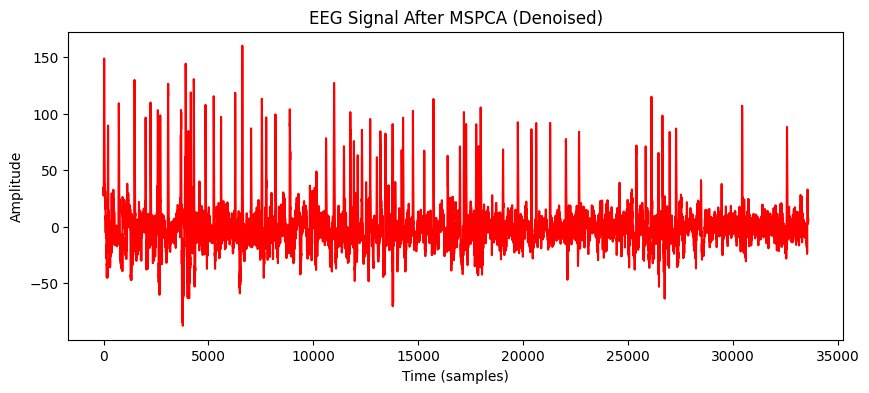

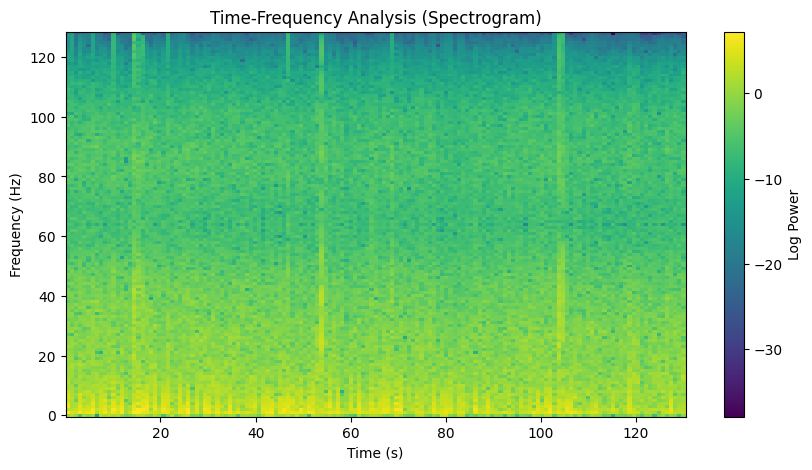

✅ Saved processed data to processed_eeg_data.csv


In [5]:
import numpy as np
import scipy.io
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, filtfilt

# **STEP 1: Load EEG Data from .mat File**
def load_mat_file(file_path):
    mat = scipy.io.loadmat(file_path)
    for key in mat.keys():
        if isinstance(mat[key], np.ndarray):  # Extract the first available ndarray
            return mat[key]
    raise ValueError("No valid EEG data found in the .mat file.")

# **STEP 2: Bandpass Filtering (Optional)**
def bandpass_filter(data, lowcut=0.5, highcut=50, fs=256, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# **STEP 3: Multi-Scale Principal Component Analysis (MSPCA)**
def apply_mspca(data, wavelet='db4', level=4):
    coeffs = pywt.wavedec(data, wavelet, level=level)

    # Thresholding to remove noise
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(data)))

    # Apply soft thresholding
    denoised_coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

    # Reconstruct the signal
    denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
    return denoised_signal

# **STEP 4: Joint Time-Frequency Analysis (JTFA)**
def apply_jtfa(data, fs=256):
    f, t, Sxx = spectrogram(data, fs)

    # Plot the Spectrogram
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(t, f, np.log(Sxx), shading='auto')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.title('Time-Frequency Analysis (Spectrogram)')
    plt.colorbar(label='Log Power')
    plt.show()

    return f, t, Sxx

# **STEP 5: Save Processed Data to CSV**
def save_to_csv(data, filename="processed_eeg_data.csv"):
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"✅ Saved processed data to {filename}")

# **MAIN FUNCTION**
if __name__ == "__main__":
    file_path = "/content/1_20160518.mat"  # Change this to your actual .mat file path
    eeg_data = load_mat_file(file_path)

    # Select a single EEG channel (Assume first row is one channel)
    eeg_signal = eeg_data[0, :]

    # **Visualizing Raw EEG Data**
    plt.figure(figsize=(10, 4))
    plt.plot(eeg_signal, color='blue')
    plt.title("Raw EEG Signal")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()

    # **Apply Bandpass Filter (Optional)**
    filtered_signal = bandpass_filter(eeg_signal)
    plt.figure(figsize=(10, 4))
    plt.plot(filtered_signal, color='green')
    plt.title("Bandpass Filtered EEG Signal (0.5 - 50 Hz)")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()

    # **Apply MSPCA**
    mspca_signal = apply_mspca(filtered_signal)
    plt.figure(figsize=(10, 4))
    plt.plot(mspca_signal, color='red')
    plt.title("EEG Signal After MSPCA (Denoised)")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()

    # **Perform Joint Time-Frequency Analysis**
    apply_jtfa(mspca_signal)

    # **Save the Processed EEG Data**
    save_to_csv(mspca_signal)


In [7]:
import scipy.io

# Load the MAT file
data = scipy.io.loadmat("/content/1_20160518.mat")

# Print all available variable names
print("Variables in .mat file:", data.keys())



Variables in .mat file: dict_keys(['__header__', '__version__', '__globals__', 'cz_eeg1', 'cz_eeg2', 'cz_eeg3', 'cz_eeg4', 'cz_eeg5', 'cz_eeg6', 'cz_eeg7', 'cz_eeg8', 'cz_eeg9', 'cz_eeg10', 'cz_eeg11', 'cz_eeg12', 'cz_eeg13', 'cz_eeg14', 'cz_eeg15', 'cz_eeg16', 'cz_eeg17', 'cz_eeg18', 'cz_eeg19', 'cz_eeg20', 'cz_eeg21', 'cz_eeg22', 'cz_eeg23', 'cz_eeg24'])


In [11]:
import scipy.io

# Load the .mat file
data = scipy.io.loadmat("/content/1_20160518.mat")

# Check the keys in the file
print(data.keys())

# Extract a specific variable (e.g., EEG signals)
eeg_data = data["cz_eeg1"]  # Replace 'EEG' with the actual variable name in your .mat file

# Print the shape of the extracted data
print(eeg_data)



dict_keys(['__header__', '__version__', '__globals__', 'cz_eeg1', 'cz_eeg2', 'cz_eeg3', 'cz_eeg4', 'cz_eeg5', 'cz_eeg6', 'cz_eeg7', 'cz_eeg8', 'cz_eeg9', 'cz_eeg10', 'cz_eeg11', 'cz_eeg12', 'cz_eeg13', 'cz_eeg14', 'cz_eeg15', 'cz_eeg16', 'cz_eeg17', 'cz_eeg18', 'cz_eeg19', 'cz_eeg20', 'cz_eeg21', 'cz_eeg22', 'cz_eeg23', 'cz_eeg24'])
[[ 2.71201134 18.29862595 13.11302185 ... 18.41783524 24.94454384
  14.33491707]
 [ 9.1791153  19.6993351  13.02361488 ... 23.33521843 27.03070641
  17.04692841]
 [ 8.82148743 16.12305641 12.72559166 ... 26.79228783 30.42817116
  22.26233482]
 ...
 [24.37829971 20.74241638 24.82533455 ...  9.05990601 12.45737076
  11.4440918 ]
 [27.74596214 22.79877663 26.34525299 ... 11.86132431 13.85807991
  11.62290573]
 [38.50460052 33.25939178 39.78610039 ... 17.1661377  16.59989357
  15.46740532]]


In [17]:
print(data.keys())  # Check all variables
cz_eeg1 = data["cz_eeg1"]  # Extract specific EEG channel


dict_keys(['__header__', '__version__', '__globals__', 'cz_eeg1', 'cz_eeg2', 'cz_eeg3', 'cz_eeg4', 'cz_eeg5', 'cz_eeg6', 'cz_eeg7', 'cz_eeg8', 'cz_eeg9', 'cz_eeg10', 'cz_eeg11', 'cz_eeg12', 'cz_eeg13', 'cz_eeg14', 'cz_eeg15', 'cz_eeg16', 'cz_eeg17', 'cz_eeg18', 'cz_eeg19', 'cz_eeg20', 'cz_eeg21', 'cz_eeg22', 'cz_eeg23', 'cz_eeg24'])
